# First analysis <a class="tocSkip">
*Beatriz Bueno-Larraz*
    
The goal of this competition is to use seismic signals to predict the timing of laboratory earthquakes. The data comes from a well-known experimental set-up used to study earthquake physics.

- The **training data** is a single, continuous segment of experimental data. 
- The **test data** consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file.

For each *seg_id* in the test folder, you should predict a single *time_to_failure* corresponding to the time between the last row of the segment and the next laboratory earthquake.

In [3]:
import os
import gc
import math
import scipy
import random
import warnings
import datetime
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.mlab import normpdf
from imblearn.over_sampling import SMOTE
from IPython.core.display import display, HTML
from statsmodels.graphics.gofplots import qqplot

warnings.filterwarnings("ignore")

random.seed(1)

In [4]:
%%time
df_train = pd.read_csv("input/train.csv", dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 1min 42s, sys: 11.4 s, total: 1min 54s
Wall time: 1min 54s


In [5]:
df_train.columns = ['signal', 'time']

Let's plot 1% of the data. For this we will sample every 100 points of data.

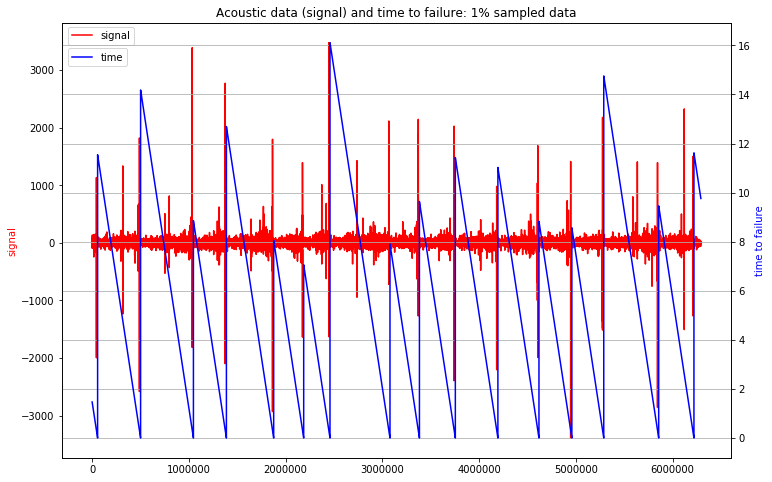

In [7]:
train_ad_sample_df = df_train['signal'].values[::100]
train_ttf_sample_df = df_train['time'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data (signal) and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('signal', color='r')
    plt.legend(['signal'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

I want to get the first complete cicle, which goes between rows 50,085,878 and 104,677,356.

In [6]:
df_cicle = df_train[50085878:104677356]
df_cicle.reset_index(inplace=True)

In [7]:
del df_train
gc.collect()

14

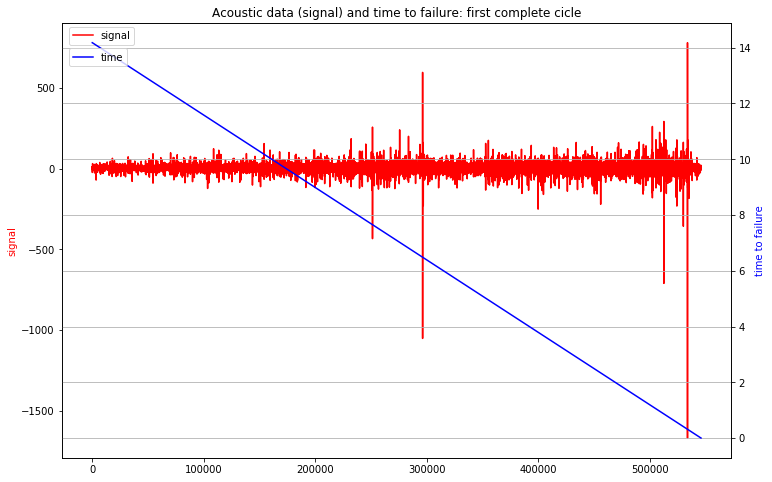

In [8]:
train_ad_sample_df = df_cicle['signal'].values[::100]
train_ttf_sample_df = df_cicle['time'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data (signal) and time to failure: first complete cicle"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('signal', color='r')
    plt.legend(['signal'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

In [123]:
print("First complete cicle has {} rows".format(df_cicle.shape[0]))

First complete cicle has 54591478 rows


In [126]:
df_cicle['signal'].describe()

count    5.459148e+07
mean     4.797263e+00
std      9.466310e+00
min     -3.112000e+03
25%      2.000000e+00
50%      5.000000e+00
75%      7.000000e+00
max      4.610000e+03
Name: signal, dtype: float64

# Repeated values

We can see in the previous summary that the main quantiles of the signal are integer numbers, which is a bit extrange... Maybe the signal has a few number of dicrete values?

In [132]:
print("Number of unique values in the signal: {}".format(df_cicle['signal'].nunique()))

Number of unique values in the signal: 2154


In [149]:
print("The {:.2f}% of the signal correspond just to 20 distintic values (less than 1% of the number of distinct values).".format(df_cicle['signal'].value_counts().reset_index().head(20)['signal'].sum()/df_cicle.shape[0]*100))

The 95.33% of the signal correspond just to 20 distintic values (less than 1% of the number of distinct values).


In [156]:
df_cicle['signal'].value_counts().reset_index().head(20)['index'].describe()

count    20.00000
mean      4.50000
std       5.91608
min      -5.00000
25%      -0.25000
50%       4.50000
75%       9.25000
max      14.00000
Name: index, dtype: float64

Comparing this summary with the one of the whole signal, we can see (as expected) that the most repeated values are in the central part of the signal. 

<font color='blue'>**Ideas:**</font>

1. 1. If there are several repeated values in a row, we could use some kind of compression to reduce the size of the signal. However, looking at the first possitions it doesn't look like there are repeated values in a row, so we can discard this idea... <font color='red'>(done)</font>
1. 2. Then we maybe could group the values to the closest one among the most commons, and then apply the compression.
1. 3. Maybe some values are repeated only around a certain period of time, so we could use those repetitions to characterice the different parts of the signal (relationship with the time). <font color='red'>(done)</font>

## Idea 1.C - Relationship between most common value and time

Using a rolling window we can compute the most common values in each window to check if there are some relationship between them and the time. In [this kernel](https://www.kaggle.com/allunia/shaking-earth) she suggest that the best window size is 50 for this data.

We compute it just for the 1% of the signal to get an idea, since the whole cicle is still too big.

In [64]:
mode50 = df_cicle[::100].rolling(window=50, center=True).apply(lambda x: stats.mode(x)[0])

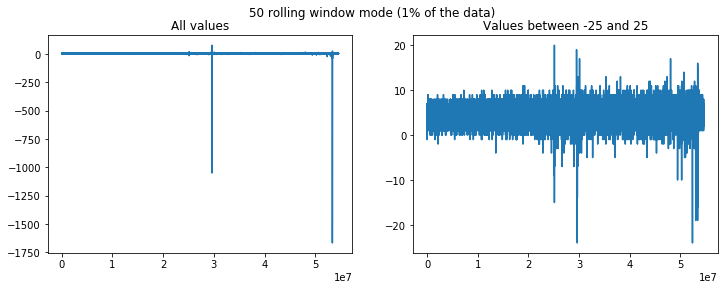

In [65]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(mode50['signal'])
plt.title("All values")
plt.subplot(1,2,2)
plt.plot(mode50[abs(mode50['signal'])<25]['signal'])
plt.title("Values between -25 and 25")
plt.suptitle("50 rolling window mode (1% of the data)")
plt.show()

It seems that with this window we capture very good the variation of the data, but it is difficult to get an idea of the shape, but using a bigger window also doesn't help, since then we lose the peaks of the signal. But we see that we are still able to recover the high peaks, so it means that **those high values are repeated several times around the peak**, and not only once. <br>
Maybe the problem is that the first, for example, 3 most common values are repeated, but they exchange the possitions. Let's then keep the fist common values and not only the mode.

In [9]:
#df_cicle[::100]['signal'].rolling(window=50, center=True).apply(lambda x: stats.mode(x)[0])
def get_top3_1(x):
    unique, counts = np.unique(x, return_counts=True)
    top3 = unique[np.argsort(counts)][-3:]
    top3.sort()
    return top3[0]

def get_top3_2(x):
    unique, counts = np.unique(x, return_counts=True)
    top3 = unique[np.argsort(counts)][-3:]
    top3.sort()
    return top3[1]

def get_top3_3(x):
    unique, counts = np.unique(x, return_counts=True)
    top3 = unique[np.argsort(counts)][-3:]
    top3.sort()
    return top3[2]

mc1 = df_cicle[::100]['signal'].rolling(window=50, center=True).apply(get_top3_1)
mc2 = df_cicle[::100]['signal'].rolling(window=50, center=True).apply(get_top3_2)
mc3 = df_cicle[::100]['signal'].rolling(window=50, center=True).apply(get_top3_3)
df_mc_top3 = pd.DataFrame([mc1,mc2,mc3]).transpose()
df_mc_top3.columns = ['mc1', 'mc2', 'mc3']

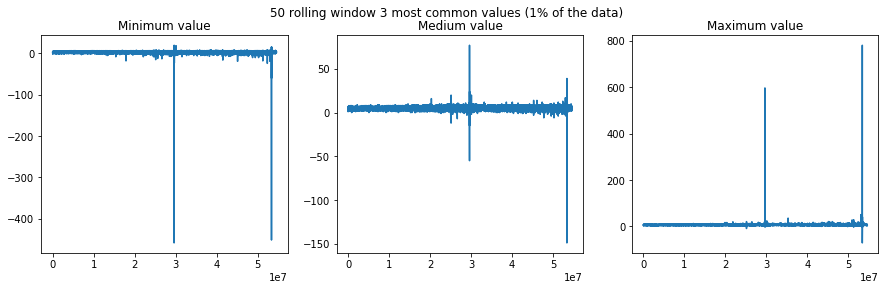

In [24]:
plt.figure(figsize=(15, 4))
plt.subplot(1,3,1)
plt.plot(df_mc_top3['mc1'])
plt.title("Minimum value")
plt.subplot(1,3,2)
plt.plot(df_mc_top3['mc2'])
plt.title("Medium value")
plt.subplot(1,3,3)
plt.plot(df_mc_top3['mc3'])
plt.title("Maximum value")
plt.suptitle("50 rolling window 3 most common values (1% of the data)")
plt.show()

In [20]:
df_mc_top3[df_mc_top3['mc1'].notnull()].groupby(['mc1','mc2','mc3']).size().reset_index().sort_values(0, ascending=False).head()

,mc1,mc2,mc3,0
1024,4.0,5.0,6.0,50935
956,3.0,4.0,5.0,31322
1078,5.0,6.0,7.0,28513
967,3.0,5.0,6.0,28202
1025,4.0,5.0,7.0,27065


Analysis of the maximum difference between values:

In [32]:
df_mc_top3[df_mc_top3['mc1'].notnull()].diff(axis=1).max(axis=1).describe()

count    545866.000000
mean          2.591436
std           8.304615
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max         930.000000
dtype: float64

We can also get the top 2 most common values.

In [21]:
def get_top2_1(x):
    unique, counts = np.unique(x, return_counts=True)
    top2 = unique[np.argsort(counts)][-2:]
    top2.sort()
    return top2[0]

def get_top2_2(x):
    unique, counts = np.unique(x, return_counts=True)
    top2 = unique[np.argsort(counts)][-2:]
    top2.sort()
    return top2[1]

mc1 = df_cicle[::100]['signal'].rolling(window=50, center=True).apply(get_top2_1)
mc2 = df_cicle[::100]['signal'].rolling(window=50, center=True).apply(get_top2_2)
df_mc_top2 = pd.DataFrame([mc1,mc2]).transpose()
df_mc_top2.columns = ['mc1', 'mc2']

In [23]:
df_mc_top2[df_mc_top2['mc1'].notnull()].groupby(['mc1','mc2']).size().reset_index().sort_values(0, ascending=False).head()

,mc1,mc2,0
270,4.0,5.0,62111
286,5.0,6.0,59265
271,4.0,6.0,50865
254,3.0,5.0,34511
287,5.0,7.0,34486


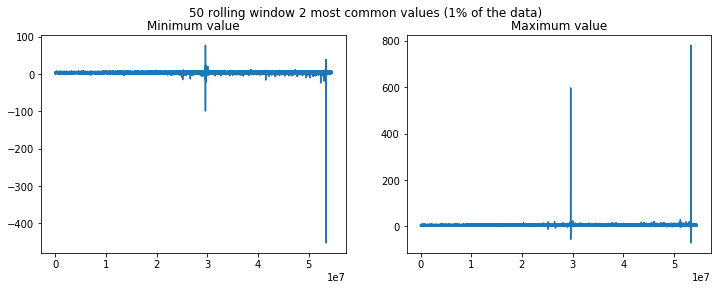

In [26]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(df_mc_top2['mc1'])
plt.title("Minimum value")
plt.subplot(1,2,2)
plt.plot(df_mc_top2['mc2'])
plt.title("Maximum value")
plt.suptitle("50 rolling window 2 most common values (1% of the data)")
plt.show()

Analysis of the maximum difference between values:

In [33]:
df_mc_top2[df_mc_top2['mc1'].notnull()].diff(axis=1).max(axis=1).describe()

count    545866.000000
mean          2.415036
std           8.926301
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max        1233.000000
dtype: float64

Comparing this with the results obtained for the first 3 values, it seems that only with 2 we are able to capture the variability of the signal. <br>
Then let's derive some features from these 2 observations and see if there is some relationship with the time.

In [43]:
df_cicle_red = df_cicle[::100]
df_cicle_red.drop('index', axis=1, inplace=True)
df_cicle_red['mc1'] = df_mc_top2['mc1']
df_cicle_red['mc2'] = df_mc_top2['mc2']

In [ ]:
df_cicle_red['mc_mean'] = (df_cicle_red['mc1']+df_cicle_red['mc2'])/2
df_cicle_red['mc_extreme'] = df_cicle_red.apply(lambda row: row['mc1'] if abs(row['mc1'])>abs(row['mc2']) else row['mc2'], axis=1)
df_cicle_red['mc_diff'] = abs(df_cicle_red['mc1']-df_cicle_red['mc2'])
df_cicle_red['mc_extreme_abs'] = abs(df_cicle_red['mc_extreme'])

In [59]:
df_cicle_red[df_cicle_red['mc1'].notnull()].head(10)

,signal,time,mc1,mc2,mc_mean,mc_extreme,mc_diff,mc_extreme_abs
2500,8,14.180597,4.0,7.0,5.5,7.0,3.0,7.0
2600,7,14.180597,4.0,7.0,5.5,7.0,3.0,7.0
2700,3,14.180597,4.0,7.0,5.5,7.0,3.0,7.0
2800,5,14.180597,4.0,7.0,5.5,7.0,3.0,7.0
2900,9,14.180596,4.0,7.0,5.5,7.0,3.0,7.0
3000,11,14.180596,4.0,7.0,5.5,7.0,3.0,7.0
3100,7,14.180596,4.0,7.0,5.5,7.0,3.0,7.0
3200,7,14.180596,4.0,7.0,5.5,7.0,3.0,7.0
3300,2,14.180596,4.0,7.0,5.5,7.0,3.0,7.0
3400,5,14.180596,4.0,7.0,5.5,7.0,3.0,7.0


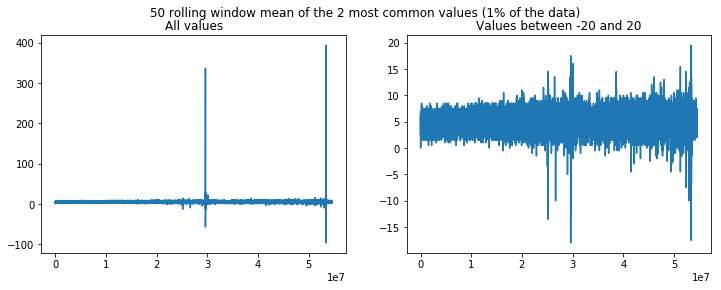

In [60]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(df_cicle_red['mc_mean'])
plt.title("All values")
plt.subplot(1,2,2)
plt.plot(df_cicle_red[df_cicle_red['mc_mean'].abs()<20]['mc_mean'])
plt.title("Values between -20 and 20")
plt.suptitle("50 rolling window mean of the 2 most common values (1% of the data)")
plt.show()

In [62]:
df_cicle_red[df_cicle_red['mc1'].notnull()].corr()

,signal,time,mc1,mc2,mc_mean,mc_extreme,mc_diff,mc_extreme_abs
signal,1.000000,-0.010356,0.115800,-0.093390,-0.051330,-0.083066,-0.111236,-0.105262
time,-0.010356,1.000000,0.007836,-0.038986,-0.042240,-0.036645,-0.032845,-0.041160
mc1,0.115800,0.007836,1.000000,-0.551297,-0.140436,-0.527754,-0.762821,-0.571586
mc2,-0.093390,-0.038986,-0.551297,1.000000,0.903463,0.995308,0.960013,0.995001
mc_mean,-0.051330,-0.042240,-0.140436,0.903463,1.000000,0.909991,0.747329,0.887106
mc_extreme,-0.083066,-0.036645,-0.527754,0.995308,0.909991,1.000000,0.948477,0.984206
mc_diff,-0.111236,-0.032845,-0.762821,0.960013,0.747329,0.948477,1.000000,0.962947
mc_extreme_abs,-0.105262,-0.041160,-0.571586,0.995001,0.887106,0.984206,0.962947,1.000000


It is a bit surprising that the correlation with the signal is so small, taking into account the large number of repeated values. However, we can see that the correlation with the time has increased, compared with using the original signal. Besides we can see that the correlation is negative, which implies that the higher is the number of big peaks, the closer we are to the hearthquake.

<font color='blue'>**Ideas:**</font>

1. 3. 1. Maybe if we remove the last part of the signal after the last big peak the correlation increases, since we can see in the first plot that the signal gets flatter between the big peak and the earthquake. <font color='red'>(Done)</font>
1. 3. 2. If it works, maybe it worths to separate the signal in two parts.

### Idea 1.C.a - Remove the last part of the signal
Let's find the biggest peak and remove the signal after that point before making the previous computing the correlations.

In [78]:
df_cicle_red.reset_index(inplace=True)
max_index = df_cicle_red['signal'].diff().abs().idxmax()

In [84]:
df_cicle_red[:max_index].corr()

,signal,time,mc1,mc2,mc_mean,mc_extreme,mc_diff,mc_extreme_abs
signal,1.000000,-0.013347,0.095685,-0.047114,-0.009823,-0.043170,-0.072897,-0.060964
time,-0.013347,1.000000,-0.002121,-0.043621,-0.045366,-0.042378,-0.036870,-0.044264
mc1,0.095685,-0.002121,1.000000,-0.246853,0.147926,-0.222682,-0.550286,-0.263945
mc2,-0.047114,-0.043621,-0.246853,1.000000,0.921876,0.994916,0.944976,0.996545
mc_mean,-0.009823,-0.045366,0.147926,0.921876,1.000000,0.926352,0.744388,0.911515
mc_extreme,-0.043170,-0.042378,-0.222682,0.994916,0.926352,1.000000,0.932435,0.986671
mc_diff,-0.072897,-0.036870,-0.550286,0.944976,0.744388,0.932435,1.000000,0.947769
mc_extreme_abs,-0.060964,-0.044264,-0.263945,0.996545,0.911515,0.986671,0.947769,1.000000


The correlation between the mean and the time has increased a little bit, so the intuition that the high of the peaks is less after the big peak was right. However the correlation between the mean and the original signal is almost 0 now, which could mean that the signal has more repeated values at the end than in the rest. Then in the rest of the signal the two most repeated values are not significative to represent it.

## Idea 1.B - Replace each value by the closest most common one
In order to do this we will use the bars of the histogram.

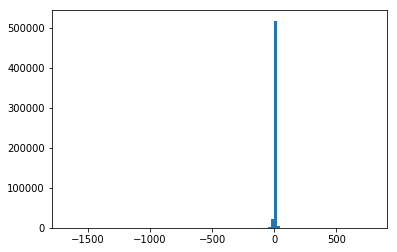

In [92]:
fig = plt.hist(df_cicle_red['signal'], bins=100)
plt.show()

In [98]:
print("There are {} non-empty bins.".format(sum(fig[0]>0)))

There are 52 non-empty bins.


In [121]:
from itertools import compress
mid_points = [int(round((a + b) / 2)) for a, b in zip(fig[1][:-1], fig[1][1:])]
points = list(compress(mid_points, fig[0]>0))

In [128]:
from bisect import bisect_left

def takeClosest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.
    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return after
    else:
       return before

new_signal = df_cicle_red['signal'].apply(lambda x: takeClosest(points,x))

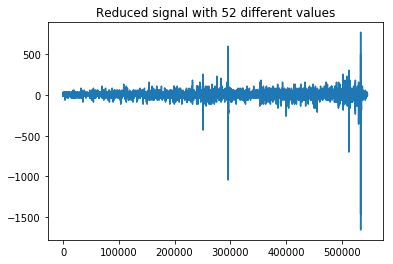

In [138]:
plt.plot(new_signal)
plt.title("Reduced signal with 52 different values")
plt.show()

In [136]:
np.corrcoef(new_signal.values, df_cicle_red['signal'].values)

array([[1.        , 0.88159748],
       [0.88159748, 1.        ]])

We see that the correlation with the original signal is pretty high, so we are lossing very few information.

In [139]:
df_cicle_red['new_signal'] = new_signal

In [151]:
print("The {:.2f}% of the new signal is equal to the same most common value (10).".format(df_cicle_red['new_signal'].value_counts().reset_index().head(1)['new_signal'].values[0]/df_cicle_red.shape[0]*100))

The 94.90% of the new signal is equal to the same most common value (10).


We can see that now there are a lot of consecutive values, so we could use some Run Length Encoding (RLE) to reduce the size of the signal and to find patterns that could help with the prediction (for instance using nearest neighbors).

In [156]:
def rle_encode(string):
    return

#rle_encode(new_signal.values)
rle_encode([1,1,1,2,2,1,3,3,3])

'3122133'

<font color='blue'>**All remaning ideas:**</font>
1. 2. Then we maybe could group the values to the closest one among the most commons, and then apply the compression.
2. Some PLS with dcov?
3. Find patterns of peaks and distance between them
4. Add the rolling mean of the 2 most common values to the features, or just the mode, for different window sizes
5. Divide the signal into before and after the big peak before deriving the features, or two different models for them.